In [12]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    import shap
except ImportError:
    print("SHAP library not found. Please install it with 'pip install shap'")
    shap = None


In [13]:
class DataAgent:
    def __init__(self, filename='credit_risk_dataset.csv'):
        self.filename = filename
        self.df = None

    def retrieve_and_preprocess(self):
        print("Agent 1: Retrieving and preprocessing data...")
        try:
            self.df = pd.read_csv(self.filename)
            print(f"Data successfully loaded from {self.filename}")
        except FileNotFoundError:
            print(f"Error: The file '{self.filename}' was not found.")
            return None, None, None, None, None

        self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
        self.df.dropna(subset=['person_emp_length'], inplace=True)

        categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
        numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                              'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        X = self.df.drop('loan_status', axis=1)
        y = self.df['loan_status']
        print("Data preprocessing complete.")
        return X, y, preprocessor, numerical_features, categorical_features

In [14]:
class VisualizationAgent:
    def __init__(self, df):
        self.df = df

    def visualize_data(self):
        if self.df is None:
            print("Visualization Agent: No data available to visualize.")
            return

        print("\nAgent 2: Generating data visualizations...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Credit Risk Dataset Visualizations', fontsize=20, y=1.02)

        sns.histplot(self.df['person_age'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Distribution of Person Age')

        sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')
        axes[0, 1].set_title('Loan Status (0=Approved, 1=Rejected)')

        sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=self.df, ax=axes[1, 0], palette='magma')
        axes[1, 0].set_title('Loan Amount vs. Income by Loan Status')

        sns.countplot(x='loan_grade', hue='loan_status', data=self.df, ax=axes[1, 1], palette='plasma')
        axes[1, 1].set_title('Loan Grade by Loan Status')

        plt.tight_layout()
        plt.show()
        print("Visualizations displayed successfully.")

In [15]:
class TrainingAgent:
    def __init__(self, preprocessor, model=RandomForestClassifier(n_estimators=100, random_state=42)):
        self.preprocessor = preprocessor
        self.model = model
        self.pipeline = None

    def train_model(self, X, y):
        print("\nAgent 3: Training and modeling...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        self.pipeline = Pipeline(steps=[('preprocessor', self.preprocessor),
                                        ('classifier', self.model)])
        self.pipeline.fit(X_train, y_train)
        print("Model training complete.")
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_val_score(self.pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
        print(f"K-fold cross-validation results (5 folds): {cv_results}")
        print(f"Mean accuracy from cross-validation: {np.mean(cv_results):.2f}")
        return self.pipeline, X_train, X_test, y_test

In [16]:
class EvaluationAgent:
    def evaluate_model(self, model, X_test, y_test):
        print("\nAgent 4: Evaluating model performance...")
        y_pred = model.predict(X_test)
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Approved', 'Rejected'], yticklabels=['Approved', 'Rejected'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

In [17]:
class PredictionAgent:
    def make_prediction(self, model, new_data):
        print("\nAgent 5: Making prediction on new data...")
        prediction = model.predict(new_data)[0]
        prediction_proba = model.predict_proba(new_data)[0]
        status = "Rejected" if prediction == 1 else "Approved"
        print(f"Prediction: {status}")
        print(f"Approval Probability: {prediction_proba[0]:.2f}, Rejection Probability: {prediction_proba[1]:.2f}")
        return prediction, new_data

In [18]:
# Alternative SHAP Explanation using TreeExplainer (for tree-based models)
def tree_shap_explanation(pipeline, new_data, X_train):
    import shap
    import matplotlib.pyplot as plt
    from IPython.display import display

    # Get preprocessor and model
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['classifier']

    # Preprocess data
    X_train_preprocessed = preprocessor.transform(X_train)
    new_data_preprocessed = preprocessor.transform(new_data)
    feature_names = preprocessor.get_feature_names_out().tolist()

    # Use TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model, X_train_preprocessed)
    shap_values = explainer.shap_values(new_data_preprocessed)

    # For binary classification, use class 1 (rejected)
    if isinstance(shap_values, list):
        shap_values_for_plot = shap_values[1]
        expected_value = explainer.expected_value[1]
    else:
        shap_values_for_plot = shap_values
        expected_value = explainer.expected_value

    # Global summary plot (feature importance)
    print("Global SHAP summary plot (feature importance):")
    shap.summary_plot(shap_values_for_plot, new_data_preprocessed, feature_names=feature_names, plot_type="bar")
    plt.show()

    # Force plot for the first prediction
    print("\nSHAP force plot for the new applicant:")
    shap.initjs()
    shap.force_plot(
        expected_value,
        shap_values_for_plot[0],
        pd.Series(new_data.iloc[0], index=feature_names),
        matplotlib=False
    )

    # Waterfall plot for the first prediction
    print("\nSHAP waterfall plot for the new applicant:")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_for_plot[0],
            base_values=expected_value,
            data=new_data_preprocessed[0],
            feature_names=feature_names
        )
    )

In [19]:
class BusinessInsightAgent:
    def __init__(self, df):
        self.df = df

    def provide_insights(self):
        if self.df is None:
            print("No data available.")
            return
        print("\nAgent 7: Business insights...")
        total_records = len(self.df)
        loan_status_counts = self.df['loan_status'].value_counts()
        approved_count = loan_status_counts.get(0, 0)
        rejected_count = loan_status_counts.get(1, 0)

        print(f"Total: {total_records}")
        print(f"Approved: {approved_count} ({approved_count/total_records:.2%})")
        print(f"Rejected: {rejected_count} ({rejected_count/total_records:.2%})")

Agent 1: Retrieving and preprocessing data...
Data successfully loaded from credit_risk_dataset.csv
Data preprocessing complete.

Agent 7: Business insights...
Total: 31686
Approved: 24860 (78.46%)
Rejected: 6826 (21.54%)

Agent 2: Generating data visualizations...


C:\Users\laiyo\AppData\Local\Temp\ipykernel_20660\2774789574.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['loan_int_rate'].fillna(self.df['loan_int_rate'].median(), inplace=True)
C:\Users\laiyo\AppData\Local\Temp\ipykernel_20660\139783436.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=self.df, ax=axes[0, 1], palette='viridis')
C:\Use

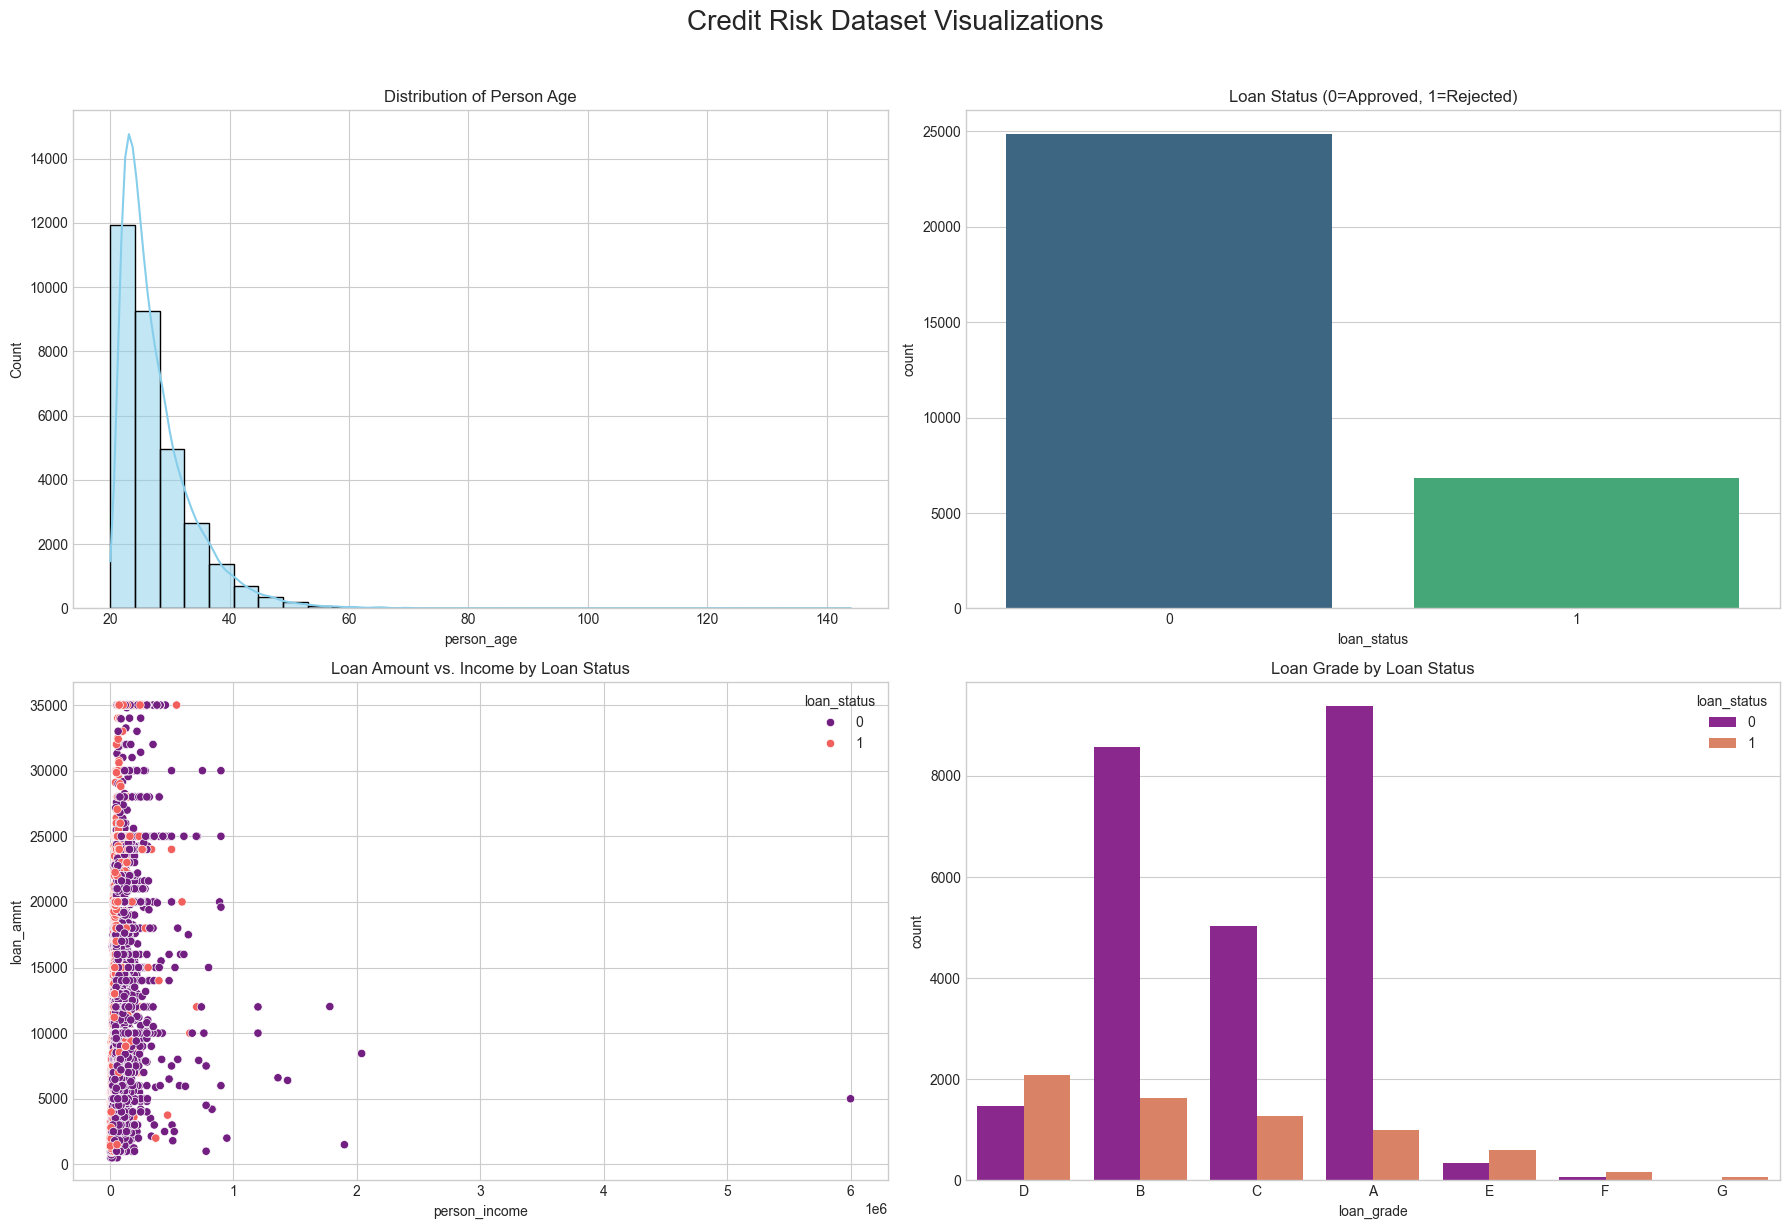

Visualizations displayed successfully.

Agent 3: Training and modeling...
Model training complete.
Model training complete.
K-fold cross-validation results (5 folds): [0.92978304 0.93451677 0.93885602 0.93726573 0.93529296]
Mean accuracy from cross-validation: 0.94

Agent 4: Evaluating model performance...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4973
           1       0.97      0.70      0.81      1365

    accuracy                           0.93      6338
   macro avg       0.95      0.85      0.89      6338
weighted avg       0.93      0.93      0.93      6338

K-fold cross-validation results (5 folds): [0.92978304 0.93451677 0.93885602 0.93726573 0.93529296]
Mean accuracy from cross-validation: 0.94

Agent 4: Evaluating model performance...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4973
          

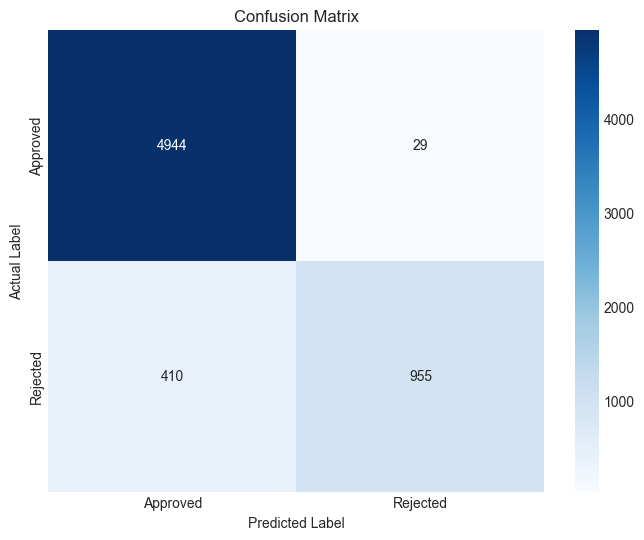

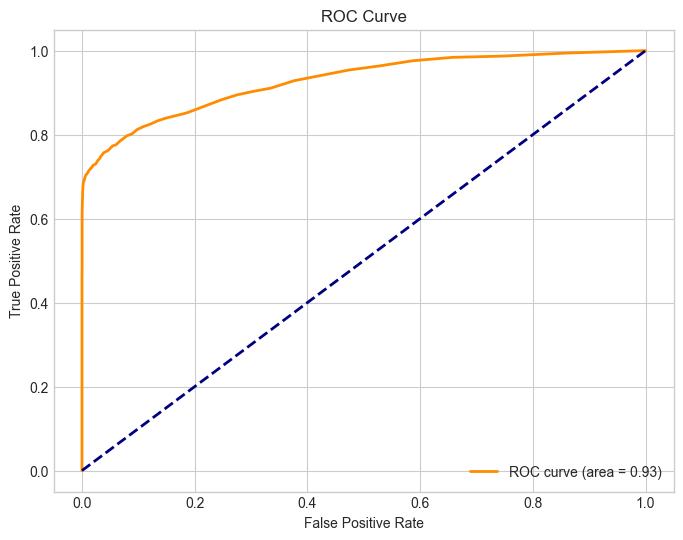


Agent 5: Making prediction on new data...
Prediction: Approved
Approval Probability: 0.97, Rejection Probability: 0.03
Global SHAP summary plot (feature importance):
Global SHAP summary plot (feature importance):


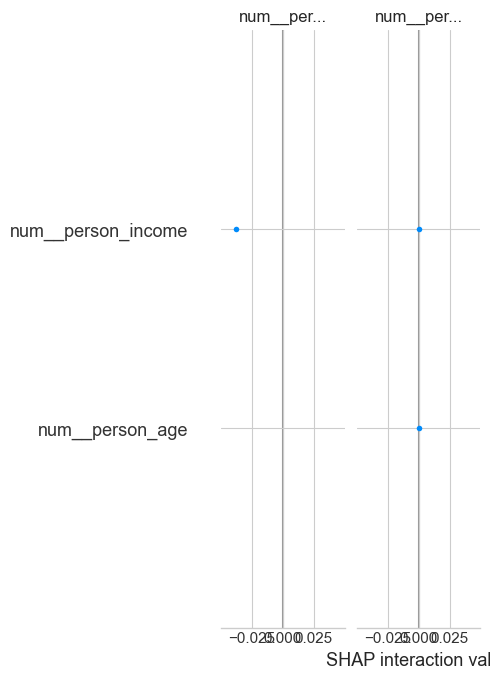


SHAP force plot for the new applicant:


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [20]:
data_agent = DataAgent()
X, y, preprocessor, num_features, cat_features = data_agent.retrieve_and_preprocess()
if X is not None:
    BusinessInsightAgent(data_agent.df).provide_insights()
    VisualizationAgent(data_agent.df).visualize_data()

    pipeline, X_train, X_test, y_test = TrainingAgent(preprocessor).train_model(X, y)
    EvaluationAgent().evaluate_model(pipeline, X_test, y_test)

    new_applicant = pd.DataFrame([{
        'person_age': 25,
        'person_income': 65000,
        'person_home_ownership': 'RENT',
        'person_emp_length': 5.0,
        'loan_intent': 'EDUCATION',
        'loan_grade': 'A',
        'loan_amnt': 15000,
        'loan_int_rate': 7.5,
        'loan_percent_income': 0.23,
        'cb_person_default_on_file': 'N',
        'cb_person_cred_hist_length': 5
    }])

    PredictionAgent().make_prediction(pipeline, new_applicant)
    tree_shap_explanation(pipeline, new_applicant, X_train)